In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from collections import Counter
import warnings
from typing import Tuple, Dict, List
import json
from datetime import datetime
import logging
import pandas as pd

# Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

IMG_SIZE = 224
DATASET_DIR = "chest_Xray"
CATEGORIES = ["NORMAL", "PNEUMONIA"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Data Loading Function
def load_images_from_folder(folder_path, label):
    """Load images from folder with enhanced preprocessing"""
    images = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist")
        return images, labels

    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

    for filename in files:
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            # Resize image
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Apply CLAHE for better contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)

            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0

            # Add channel dimension
            img = np.expand_dims(img, axis=0)

            images.append(img)
            labels.append(label)

        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return images, labels

X_train = []
y_train = []
X_test = []
y_test = []

# Load training and validation data
for dataset_type in ["train", "val"]:
    for idx, category in enumerate(CATEGORIES):
        folder_path = os.path.join(DATASET_DIR, dataset_type, category)
        imgs, labels = load_images_from_folder(folder_path, idx)
        X_train.extend(imgs)
        y_train.extend(labels)

# Load test data
for idx, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, "test", category)
    imgs, labels = load_images_from_folder(folder_path, idx)
    X_test.extend(imgs)
    y_test.extend(labels)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Combined training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels distribution: {Counter(y_train)}")
print(f"Test labels distribution: {Counter(y_test)}")

# Split combined training data into train/val (80/20)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED
)

print(f"\nAfter 80/20 split:")
print(f"Train: {X_train_split.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train labels: {Counter(y_train_split)}")
print(f"Val labels: {Counter(y_val)}")

Combined training data shape: (5232, 1, 224, 224)
Test data shape: (624, 1, 224, 224)
Training labels distribution: Counter({np.int64(1): 3883, np.int64(0): 1349})
Test labels distribution: Counter({np.int64(1): 390, np.int64(0): 234})

After 80/20 split:
Train: (4185, 1, 224, 224), Val: (1047, 1, 224, 224), Test: (624, 1, 224, 224)
Train labels: Counter({np.int64(1): 3106, np.int64(0): 1079})
Val labels: Counter({np.int64(1): 777, np.int64(0): 270})


In [3]:
# Improved CNN Architecture
class ImprovedChestXRayCNN(nn.Module):
    """Improved CNN architecture for better accuracy"""

    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(ImprovedChestXRayCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Create model
model = ImprovedChestXRayCNN(num_classes=2, dropout_rate=0.3).to(DEVICE)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 14887234 parameters


In [4]:
# Enhanced Training Setup
def create_balanced_sampler(labels):
    """Create weighted sampler for class imbalance"""
    class_counts = Counter(labels)
    total_samples = len(labels)
    class_weights = {
        cls: total_samples / (len(class_counts) * count)
        for cls, count in class_counts.items()
    }
    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights, num_samples=len(sample_weights), replacement=True
    )


# Create datasets and data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_split), torch.LongTensor(y_train_split)
)
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

# Create balanced sampler for training
train_sampler = create_balanced_sampler(y_train_split)

# Data loaders
batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

print(f"Data loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data loaders created:
Train batches: 131
Val batches: 33
Test batches: 20


In [5]:
# Enhanced Training Function
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train model with improved strategy"""

    # Loss function with class weights
    class_counts = Counter(y_train_split)
    total_samples = len(y_train_split)
    class_weights = [
        total_samples / (len(class_counts) * class_counts[i])
        for i in range(len(CATEGORIES))
    ]
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(
        [
            {"params": model.features.parameters(), "lr": learning_rate * 0.1},
            {"params": model.classifier.parameters(), "lr": learning_rate},
        ],
        weight_decay=1e-4,
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-7
    )

    # Training history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    best_val_f1 = 0.0
    patience_counter = 0
    patience = 2

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        # Calculate F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average="weighted"
        )
        val_f1 = f1

        # Update history
        history["train_loss"].append(train_loss_avg)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss_avg)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Step scheduler
        scheduler.step(val_f1)

        # Print progress
        print(f"Epoch [{epoch + 1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f}")
        print(
            f"  Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  *** New best F1: {best_val_f1:.4f} - Model saved ***")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print("-" * 60)

    # Load best model
    model.load_state_dict(torch.load("best_model.pth"))
    return history


# Train the model
print("Starting training...")
history = train_model(
    model, train_loader, val_loader, num_epochs=5, learning_rate=0.001
)

Starting training...
Epoch [1/5]:
  Train Loss: 0.3089, Train Acc: 0.8495
  Val Loss: 0.2187, Val Acc: 0.9160, Val F1: 0.9181
  Learning Rate: 0.000100
  *** New best F1: 0.9181 - Model saved ***
------------------------------------------------------------
Epoch [2/5]:
  Train Loss: 0.1863, Train Acc: 0.9097
  Val Loss: 0.1536, Val Acc: 0.9341, Val F1: 0.9355
  Learning Rate: 0.000100
  *** New best F1: 0.9355 - Model saved ***
------------------------------------------------------------
Epoch [3/5]:
  Train Loss: 0.1505, Train Acc: 0.9262
  Val Loss: 0.2334, Val Acc: 0.8797, Val F1: 0.8857
  Learning Rate: 0.000100
------------------------------------------------------------
Epoch [4/5]:
  Train Loss: 0.1257, Train Acc: 0.9393
  Val Loss: 0.1119, Val Acc: 0.9446, Val F1: 0.9460
  Learning Rate: 0.000100
  *** New best F1: 0.9460 - Model saved ***
------------------------------------------------------------
Epoch [5/5]:
  Train Loss: 0.1132, Train Acc: 0.9491
  Val Loss: 0.1371, Val Ac

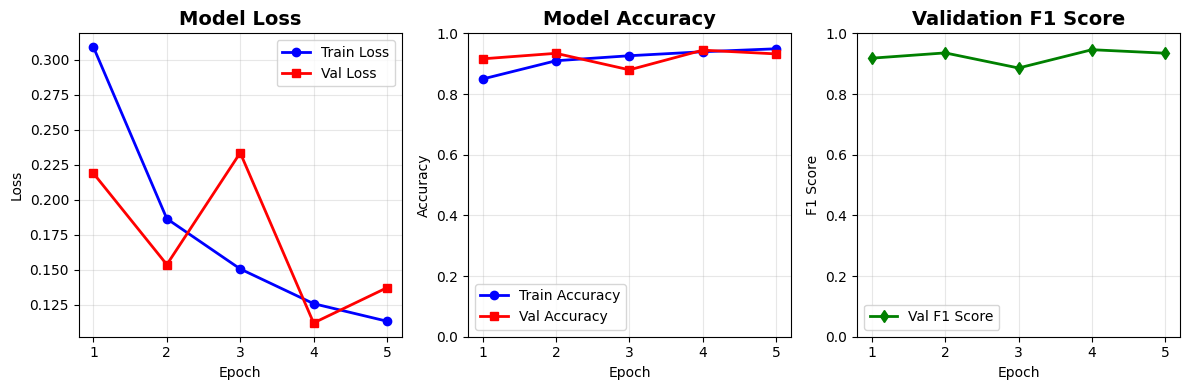

In [6]:
# Training History Plot
def plot_training_history(history):
    """Plot training history with  subplots"""

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], "b-o", label="Train Loss", linewidth=2)
    plt.plot(epochs, history["val_loss"], "r-s", label="Val Loss", linewidth=2)
    plt.title("Model Loss", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], "b-o", label="Train Accuracy", linewidth=2)
    plt.plot(epochs, history["val_acc"], "r-s", label="Val Accuracy", linewidth=2)
    plt.title("Model Accuracy", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_f1"], "g-d", label="Val F1 Score", linewidth=2)
    plt.title("Validation F1 Score", fontsize=14, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)

In [7]:
# Comprehensive Error Analysis
def comprehensive_error_analysis(model, test_loader, categories):
    """Perform comprehensive error analysis"""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    misclassified_indices = []
    confidence_scores = []

    with torch.no_grad():
        batch_idx = 0
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # Get confidence scores (max probability)
            batch_confidence = torch.max(probs, dim=1)[0]
            confidence_scores.extend(batch_confidence.cpu().numpy())

            # Track misclassifications
            for i in range(len(labels)):
                global_idx = batch_idx * test_loader.batch_size + i
                if predicted[i] != labels[i]:
                    misclassified_indices.append(
                        {
                            "index": global_idx,
                            "true_label": labels[i].item(),
                            "predicted_label": predicted[i].item(),
                            "confidence": batch_confidence[i].item(),
                        }
                    )

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            batch_idx += 1

    # Calculate comprehensive metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    print("\n" + "=" * 60)
    print("COMPREHENSIVE ERROR ANALYSIS")
    print("=" * 60)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Total Misclassifications: {len(misclassified_indices)}")
    print(f"Error Rate: {len(misclassified_indices) / len(all_labels):.4f}")

    print("\nClass-wise Performance:")
    for i, category in enumerate(categories):
        print(f"{category}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]}")

    # Analyze misclassifications by class
    print("\nMisclassification Analysis:")
    for i, true_class in enumerate(categories):
        for j, pred_class in enumerate(categories):
            if i != j:
                count = sum(
                    1
                    for error in misclassified_indices
                    if error["true_label"] == i and error["predicted_label"] == j
                )
                if count > 0:
                    print(f"  {true_class} → {pred_class}: {count} cases")

    # Confidence analysis
    correct_mask = np.array(all_labels) == np.array(all_preds)
    correct_confidence = np.array(confidence_scores)[correct_mask]
    incorrect_confidence = np.array(confidence_scores)[~correct_mask]

    print(f"\nConfidence Analysis:")
    print(f"  Correct predictions avg confidence: {np.mean(correct_confidence):.4f}")
    print(
        f"  Incorrect predictions avg confidence: {np.mean(incorrect_confidence):.4f}"
    )
    print(
        f"  Low confidence predictions (<0.7): {sum(1 for c in confidence_scores if c < 0.7)}"
    )

    return all_labels, all_preds, all_probs, misclassified_indices, confidence_scores


# Run comprehensive error analysis
all_labels, all_preds, all_probs, misclassified_indices, confidence_scores = (
    comprehensive_error_analysis(model, test_loader, CATEGORIES)
)


COMPREHENSIVE ERROR ANALYSIS
Overall Accuracy: 0.8125
Total Misclassifications: 117
Error Rate: 0.1875

Class-wise Performance:
NORMAL:
  Precision: 0.8874
  Recall: 0.5726
  F1-Score: 0.6961
  Support: 234
PNEUMONIA:
  Precision: 0.7886
  Recall: 0.9564
  F1-Score: 0.8644
  Support: 390

Misclassification Analysis:
  NORMAL → PNEUMONIA: 100 cases
  PNEUMONIA → NORMAL: 17 cases

Confidence Analysis:
  Correct predictions avg confidence: 0.9292
  Incorrect predictions avg confidence: 0.8172
  Low confidence predictions (<0.7): 69


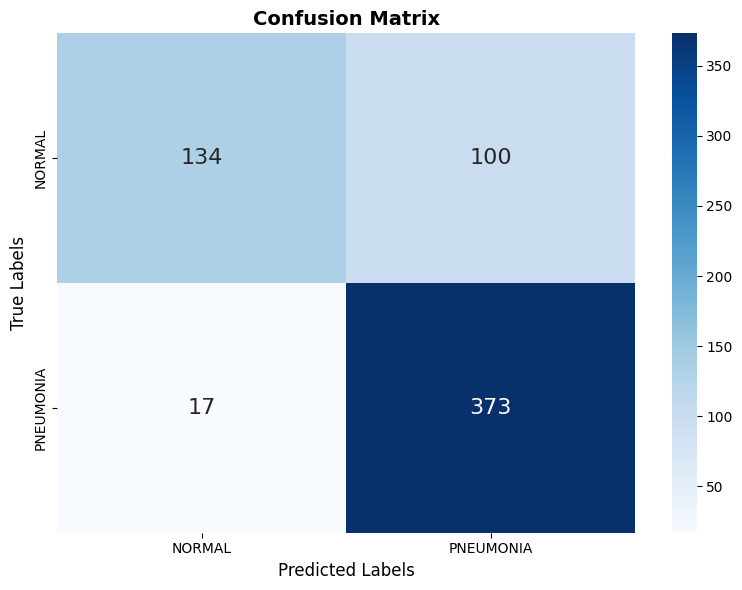

In [8]:
# Confusion Matrix Plot
def plot_confusion_matrix(all_labels, all_preds, categories):
    """Plot confusion matrix"""
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=categories,
        yticklabels=categories,
        annot_kws={"size": 16},
    )
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    return cm


# Plot confusion matrix
cm = plot_confusion_matrix(all_labels, all_preds, CATEGORIES)

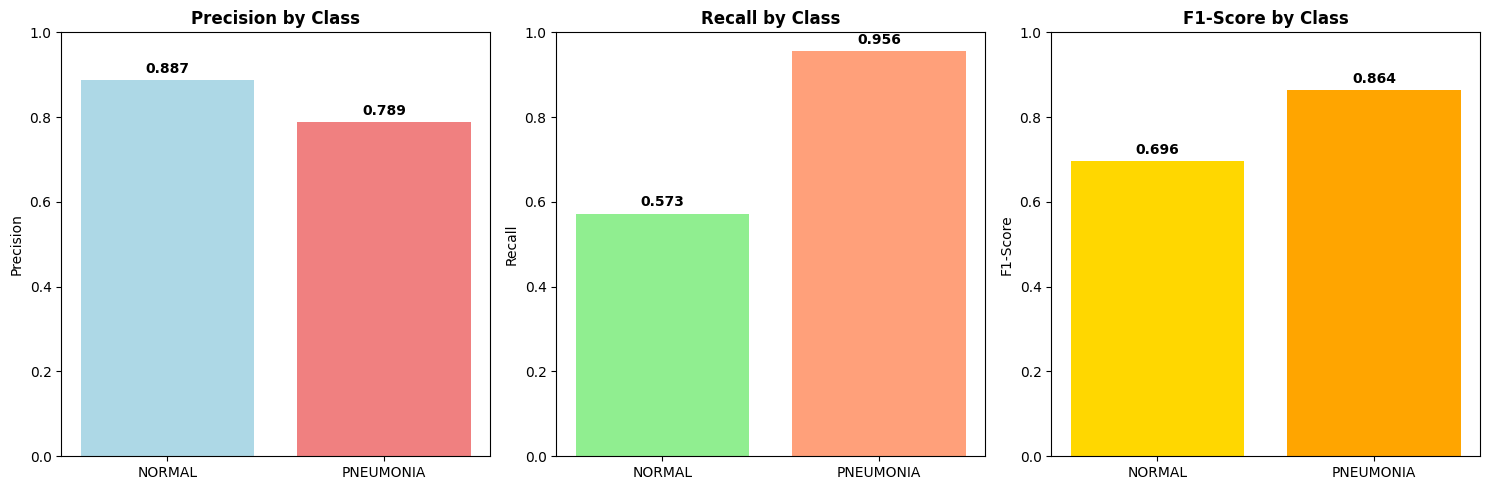

In [9]:
# Class-wise Performance Plot
def plot_class_performance(all_labels, all_preds, categories):
    """Plot class-wise performance metrics"""
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Precision
    bars1 = axes[0].bar(categories, precision, color=["lightblue", "lightcoral"])
    axes[0].set_title("Precision by Class", fontweight="bold")
    axes[0].set_ylabel("Precision")
    axes[0].set_ylim(0, 1)
    for bar, p in zip(bars1, precision):
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{p:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Recall
    bars2 = axes[1].bar(categories, recall, color=["lightgreen", "lightsalmon"])
    axes[1].set_title("Recall by Class", fontweight="bold")
    axes[1].set_ylabel("Recall")
    axes[1].set_ylim(0, 1)
    for bar, r in zip(bars2, recall):
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{r:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # F1-Score
    bars3 = axes[2].bar(categories, f1, color=["gold", "orange"])
    axes[2].set_title("F1-Score by Class", fontweight="bold")
    axes[2].set_ylabel("F1-Score")
    axes[2].set_ylim(0, 1)
    for bar, f in zip(bars3, f1):
        axes[2].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{f:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


# Plot class-wise performance
plot_class_performance(all_labels, all_preds, CATEGORIES)

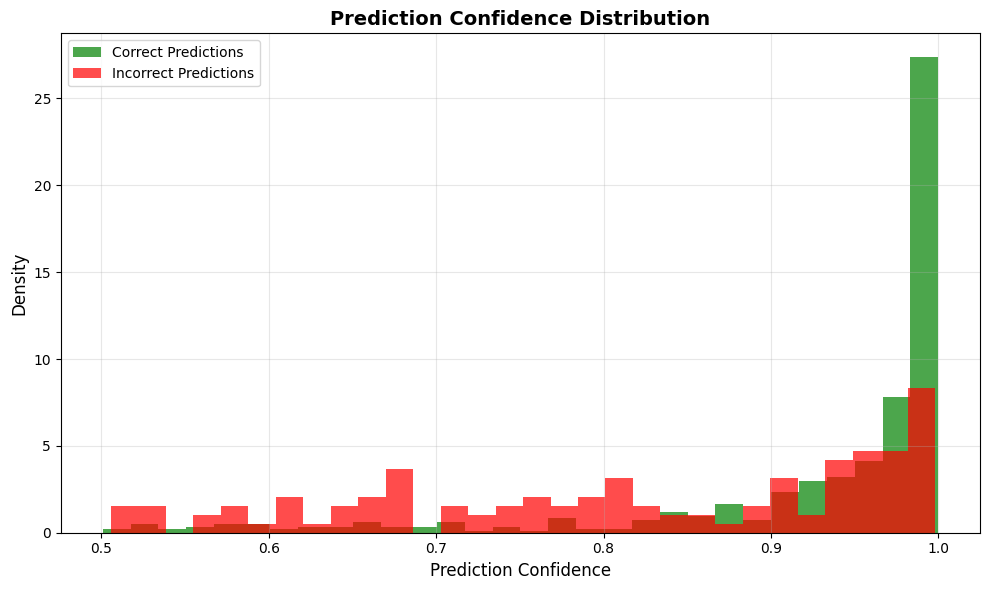

In [10]:
# Confidence Distribution Plot
def plot_confidence_distribution(all_labels, all_preds, confidence_scores):
    """Plot confidence score distribution"""
    correct_mask = np.array(all_labels) == np.array(all_preds)
    correct_confidence = np.array(confidence_scores)[correct_mask]
    incorrect_confidence = np.array(confidence_scores)[~correct_mask]

    plt.figure(figsize=(10, 6))
    plt.hist(
        correct_confidence,
        bins=30,
        alpha=0.7,
        label="Correct Predictions",
        color="green",
        density=True,
    )
    plt.hist(
        incorrect_confidence,
        bins=30,
        alpha=0.7,
        label="Incorrect Predictions",
        color="red",
        density=True,
    )
    plt.xlabel("Prediction Confidence", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Prediction Confidence Distribution", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot confidence distribution
plot_confidence_distribution(all_labels, all_preds, confidence_scores)

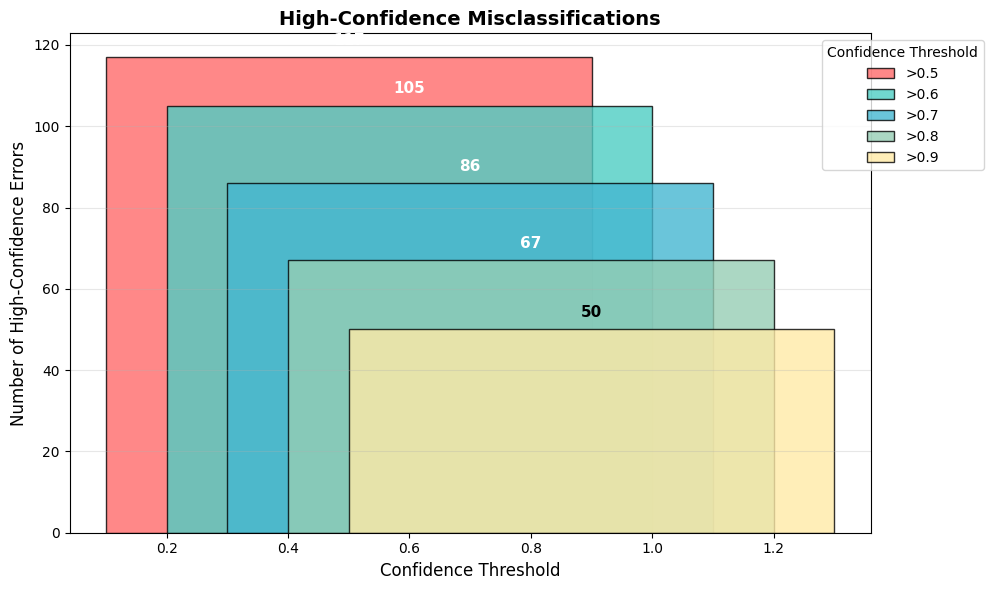


High-Confidence Error Analysis:

Errors with confidence > 0.8: 67
  Index 11: NORMAL → PNEUMONIA (conf: 0.960)
  Index 14: NORMAL → PNEUMONIA (conf: 0.820)
  Index 16: NORMAL → PNEUMONIA (conf: 0.998)
  Index 40: NORMAL → PNEUMONIA (conf: 0.997)
  Index 45: NORMAL → PNEUMONIA (conf: 0.982)

Errors with confidence > 0.9: 50
  Index 11: NORMAL → PNEUMONIA (conf: 0.960)
  Index 16: NORMAL → PNEUMONIA (conf: 0.998)
  Index 40: NORMAL → PNEUMONIA (conf: 0.997)
  Index 45: NORMAL → PNEUMONIA (conf: 0.982)
  Index 46: NORMAL → PNEUMONIA (conf: 0.986)


In [11]:
# Error Analysis by Confidence Threshold
def analyze_errors_by_confidence(misclassified_indices, categories):
    """Analyze errors by confidence threshold"""
    confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    error_counts = []

    for threshold in confidence_thresholds:
        count = sum(
            1 for error in misclassified_indices if error["confidence"] > threshold
        )
        error_counts.append(count)

    # Use distinct colors for each bar
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(confidence_thresholds, error_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    plt.xlabel("Confidence Threshold", fontsize=12)
    plt.ylabel("Number of High-Confidence Errors", fontsize=12)
    plt.title("High-Confidence Misclassifications", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars with contrasting colors
    for i, (bar, count) in enumerate(zip(bars, error_counts)):
        plt.text(
            confidence_thresholds[i],
            count + max(error_counts) * 0.02, 
            str(count),
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=11,
            color='white' if count > max(error_counts) * 0.5 else 'black'
        )

    # Add a color legend
    threshold_labels = [f'>{thresh}' for thresh in confidence_thresholds]
    plt.legend(bars, threshold_labels, title="Confidence Threshold", 
               loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nHigh-Confidence Error Analysis:")
    for threshold in [0.8, 0.9]:
        high_conf_errors = [
            error for error in misclassified_indices if error["confidence"] > threshold
        ]
        print(f"\nErrors with confidence > {threshold}: {len(high_conf_errors)}")
        for error in high_conf_errors[:5]:
            true_label = categories[error["true_label"]]
            pred_label = categories[error["predicted_label"]]
            print(
                f"  Index {error['index']}: {true_label} → {pred_label} (conf: {error['confidence']:.3f})"
            )
 
# Analyze errors by confidence
analyze_errors_by_confidence(misclassified_indices, CATEGORIES)

In [12]:
# Classification Report
def print_detailed_classification_report(all_labels, all_preds, categories):
    """Print detailed classification report"""
    print("\n" + "=" * 60)
    print("DETAILED CLASSIFICATION REPORT")
    print("=" * 60)

    report = classification_report(
        all_labels, all_preds, target_names=categories, output_dict=True
    )
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Additional insights
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Class distribution in test set
    print("\nTest Set Distribution:")
    for i, category in enumerate(categories):
        count = sum(1 for label in all_labels if label == i)
        percentage = (count / len(all_labels)) * 100
        print(f"  {category}: {count} samples ({percentage:.1f}%)")

    return report


# Print detailed classification report
report = print_detailed_classification_report(all_labels, all_preds, CATEGORIES)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       0.89      0.57      0.70       234
   PNEUMONIA       0.79      0.96      0.86       390

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624


Overall Accuracy: 0.8125

Test Set Distribution:
  NORMAL: 234 samples (37.5%)
  PNEUMONIA: 390 samples (62.5%)


In [13]:
# Enhanced Error Analysis with Image Saving
def save_misclassified_images_analysis(model, test_loader, categories, results_dir="results_cnn_vanilla"):
    """Analyze errors and save misclassified images to organized folders"""
    import shutil
    from PIL import Image
    
    model.eval()
    
    # Create misclassifications directory structure
    misclassifications_dir = os.path.join(results_dir, "misclassifications")
    normal_dir = os.path.join(misclassifications_dir, "normal")
    pneumonia_dir = os.path.join(misclassifications_dir, "pneumonia")
    
    # Create directories if they don't exist
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(pneumonia_dir, exist_ok=True)
    
    # Clear existing files
    for folder in [normal_dir, pneumonia_dir]:
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    
    all_preds = []
    all_labels = []
    all_probs = []
    misclassified_data = []
    confidence_scores = []
    
    print("Analyzing misclassifications and saving images...")
    
    with torch.no_grad():
        global_idx = 0
        for batch_idx, (images, labels) in enumerate(test_loader):
            images_device, labels_device = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images_device)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Get confidence scores
            batch_confidence = torch.max(probs, dim=1)[0]
            confidence_scores.extend(batch_confidence.cpu().numpy())
            
            # Process each image in the batch
            for i in range(len(labels)):
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                confidence = batch_confidence[i].item()
                
                # If misclassified, save the image
                if pred_label != true_label:
                    # Get the original image (denormalize if needed)
                    img_array = images[i].squeeze().numpy()  # Remove batch and channel dims
                    
                    # Convert to PIL Image and save
                    img_pil = Image.fromarray((img_array * 255).astype(np.uint8))
                    
                    # Determine save directory based on true label
                    if true_label == 0:  # NORMAL
                        save_dir = normal_dir
                        true_class = "NORMAL"
                    else:  # PNEUMONIA
                        save_dir = pneumonia_dir
                        true_class = "PNEUMONIA"
                    
                    pred_class = categories[pred_label]
                    
                    # Create filename with detailed info
                    filename = f"misclassified_{global_idx:04d}_true_{true_class}_pred_{pred_class}_conf_{confidence:.3f}.png"
                    img_path = os.path.join(save_dir, filename)
                    img_pil.save(img_path)
                    
                    # Store misclassification data
                    misclassified_data.append({
                        "global_index": global_idx,
                        "batch_index": batch_idx,
                        "image_index": i,
                        "true_label": true_label,
                        "predicted_label": pred_label,
                        "true_class": true_class,
                        "predicted_class": pred_class,
                        "confidence": confidence,
                        "image_path": img_path
                    })
                
                all_preds.append(pred_label)
                all_labels.append(true_label)
                all_probs.append(probs[i].cpu().numpy())
                global_idx += 1
    
    print(f"Saved {len(misclassified_data)} misclassified images")
    print(f"Normal misclassifications: {len(os.listdir(normal_dir))}")
    print(f"Pneumonia misclassifications: {len(os.listdir(pneumonia_dir))}")
    
    return all_labels, all_preds, all_probs, misclassified_data, confidence_scores

# Run the enhanced error analysis
all_labels, all_preds, all_probs, misclassified_data, confidence_scores = save_misclassified_images_analysis(
    model, test_loader, CATEGORIES, "results_cnn_vanilla"
)

Analyzing misclassifications and saving images...
Saved 117 misclassified images
Normal misclassifications: 100
Pneumonia misclassifications: 17


In [14]:
# Detailed Misclassification Analysis and Reporting
def analyze_and_report_misclassifications(misclassified_data, categories, results_dir="results_cnn_vanilla"):
    """Generate detailed analysis report of misclassifications"""
    
    # Create analysis dataframe
    df_errors = pd.DataFrame(misclassified_data)
    
    print("\n" + "="*80)
    print("DETAILED MISCLASSIFICATION ANALYSIS")
    print("="*80)
    
    # Overall statistics
    total_errors = len(misclassified_data)
    print(f"Total Misclassifications: {total_errors}")
    
    # Error breakdown by true class
    print("\nErrors by True Class:")
    for true_class in categories:
        count = len(df_errors[df_errors['true_class'] == true_class])
        percentage = (count / total_errors) * 100 if total_errors > 0 else 0
        print(f"  {true_class}: {count} errors ({percentage:.1f}%)")
    
    # Error breakdown by prediction
    print("\nErrors by Predicted Class:")
    for pred_class in categories:
        count = len(df_errors[df_errors['predicted_class'] == pred_class])
        percentage = (count / total_errors) * 100 if total_errors > 0 else 0
        print(f"  {pred_class}: {count} errors ({percentage:.1f}%)")
    
    # Confidence analysis
    print("\nConfidence Analysis of Misclassifications:")
    confidences = df_errors['confidence'].values
    print(f"  Average Confidence: {np.mean(confidences):.4f}")
    print(f"  Median Confidence: {np.median(confidences):.4f}")
    print(f"  Min Confidence: {np.min(confidences):.4f}")
    print(f"  Max Confidence: {np.max(confidences):.4f}")
    
    # High confidence errors (concerning cases)
    high_conf_threshold = 0.8
    high_conf_errors = df_errors[df_errors['confidence'] > high_conf_threshold]
    print(f"\nHigh Confidence Errors (>{high_conf_threshold}):")
    print(f"  Count: {len(high_conf_errors)}")
    if len(high_conf_errors) > 0:
        print("  Most concerning cases:")
        for _, error in high_conf_errors.head(5).iterrows():
            print(f"    {error['true_class']} → {error['predicted_class']} (conf: {error['confidence']:.3f})")
    
    # Save detailed CSV report
    csv_path = os.path.join(results_dir, "misclassifications", "detailed_error_analysis.csv")
    df_errors.to_csv(csv_path, index=False)
    print(f"\nDetailed error data saved to: {csv_path}")
    
    # Create summary statistics
    summary_stats = {
        "total_misclassifications": total_errors,
        "errors_by_true_class": df_errors['true_class'].value_counts().to_dict(),
        "errors_by_predicted_class": df_errors['predicted_class'].value_counts().to_dict(),
        "confidence_statistics": {
            "mean": float(np.mean(confidences)),
            "median": float(np.median(confidences)),
            "min": float(np.min(confidences)),
            "max": float(np.max(confidences)),
            "std": float(np.std(confidences))
        },
        "high_confidence_errors": len(high_conf_errors),
        "high_confidence_threshold": high_conf_threshold
    }
    
    # Save summary JSON
    summary_path = os.path.join(results_dir, "misclassifications", "error_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary_stats, f, indent=4)
    print(f"Summary statistics saved to: {summary_path}")
    
    return df_errors, summary_stats

# Run the detailed analysis
df_errors, summary_stats = analyze_and_report_misclassifications(
    misclassified_data, CATEGORIES, "results_cnn_vanilla"
)


DETAILED MISCLASSIFICATION ANALYSIS
Total Misclassifications: 117

Errors by True Class:
  NORMAL: 100 errors (85.5%)
  PNEUMONIA: 17 errors (14.5%)

Errors by Predicted Class:
  NORMAL: 17 errors (14.5%)
  PNEUMONIA: 100 errors (85.5%)

Confidence Analysis of Misclassifications:
  Average Confidence: 0.8172
  Median Confidence: 0.8339
  Min Confidence: 0.5056
  Max Confidence: 0.9982

High Confidence Errors (>0.8):
  Count: 67
  Most concerning cases:
    NORMAL → PNEUMONIA (conf: 0.960)
    NORMAL → PNEUMONIA (conf: 0.820)
    NORMAL → PNEUMONIA (conf: 0.998)
    NORMAL → PNEUMONIA (conf: 0.997)
    NORMAL → PNEUMONIA (conf: 0.982)

Detailed error data saved to: results_cnn_vanilla\misclassifications\detailed_error_analysis.csv
Summary statistics saved to: results_cnn_vanilla\misclassifications\error_summary.json


In [15]:
# Save Results and Model
def save_results(model, history, report, cm, misclassified_indices):
    """Save all results and model"""
    results_dir = "results_cnn_vanilla"
    os.makedirs(results_dir, exist_ok=True)

    # Save model
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "model_architecture": str(model),
            "final_accuracy": report["accuracy"] if "accuracy" in report else 0,
        },
        f"{results_dir}/improved_model.pth",
    )

    # Save training history
    history_df = pd.DataFrame(history)
    history_df.to_parquet(f"{results_dir}/training_history.parquet", index=False)

    # Save classification report
    report_df = pd.DataFrame(report).T
    report_df.to_parquet(f"{results_dir}/classification_report.parquet")

    # Save confusion matrix
    cm_df = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
    cm_df.to_parquet(f"{results_dir}/confusion_matrix.parquet")

    # Save error analysis
    error_df = pd.DataFrame(misclassified_indices)
    error_df.to_parquet(f"{results_dir}/misclassified_samples.parquet", index=False)

    # Save summary
    summary = {
        "final_accuracy": float(report["accuracy"]) if "accuracy" in report else 0,
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "training_epochs": len(history["train_loss"]),
        "total_misclassifications": len(misclassified_indices),
        "categories": CATEGORIES,
        "model_improvements": [
            "Deeper CNN architecture with VGG-like structure",
            "Batch normalization after each conv layer",
            "Dropout for regularization",
            "Global average pooling instead of flatten",
            "Class-balanced weighted loss function",
            "AdamW optimizer with different learning rates",
            "Learning rate scheduling",
            "CLAHE preprocessing for better contrast",
            "Comprehensive error analysis",
        ],
    }

    with open(f"{results_dir}/summary.json", "w") as f:
        json.dump(summary, f, indent=4)

    print(f"\nAll results saved to {results_dir}/")
    print("Files saved")


# Save all results
save_results(model, history, report, cm, misclassified_indices)


All results saved to results_cnn_vanilla/
Files saved
